In [1]:
import numpy as np
import gym

from keras import initializers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.agents import CEMAgent
from rl.memory import SequentialMemory
from rl.memory import EpisodeParameterMemory
from rl.random import OrnsteinUhlenbeckProcess

import matplotlib.pyplot as plt
%matplotlib inline

ENV_NAME = 'CoolingFin-v0'
gym.undo_logger_setup()


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
#np.random.seed(123)
#env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.
actor = Sequential()
#actor.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(260,kernel_initializer=initializers.RandomNormal(stddev=0.01)))
actor.add(Activation('relu'))
actor.add(Dense(100,kernel_initializer=initializers.RandomNormal(stddev=0.01)))
actor.add(Activation('relu'))
actor.add(Dense(50,kernel_initializer=initializers.RandomNormal(stddev=0.01)))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions,kernel_initializer=initializers.RandomNormal(stddev=0.01)))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(150)(x)
x = Activation('relu')(x)
x = Dense(90)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
#critic.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = EpisodeParameterMemory(limit=100000, window_length=1)
#random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=1.5, mu=0, sigma=1)
agent = CEMAgent(model=actor, nb_actions=nb_actions, memory=memory,
               batch_size=1000, nb_steps_warmup=2000, train_interval=500, elite_frac=0.05,noise_decay_const=0.0001, noise_ampl=100.0)
#agent.compile(Adam(lr=.00001, clipnorm=1.), metrics=['mae'])
agent.compile()

Using TensorFlow backend.
C:\Users\stevenbc\Anaconda3\lib\site-packages\gym\__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 22)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 260)               5980      
_________________________________________________________________
activation_1 (Activation)    (None, 260)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               26100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
___

Training for 60000 steps ...
Interval 1 (0 steps performed)
6000/6000 [==============================] - 113s 19ms/step - reward: 1013.8088
5986 episodes - episode_reward: 1016.180 [871.801, 4923.335] - mean_best_reward: 1156.387

Interval 2 (6000 steps performed)
6000/6000 [==============================] - 124s 21ms/step - reward: 1017.5907
6000 episodes - episode_reward: 1017.591 [878.168, 1161.707] - mean_best_reward: 1130.935

Interval 3 (12000 steps performed)
6000/6000 [==============================] - 127s 21ms/step - reward: 1017.6101
6000 episodes - episode_reward: 1017.610 [869.523, 1166.525] - mean_best_reward: 1124.729

Interval 4 (18000 steps performed)
6000/6000 [==============================] - 118s 20ms/step - reward: 1016.9509
6000 episodes - episode_reward: 1016.951 [876.387, 1165.030] - mean_best_reward: 1119.007

Interval 5 (24000 steps performed)
6000/6000 [==============================] - 121s 20ms/step - reward: 1017.9824
6000 episodes - episode_reward: 1017.

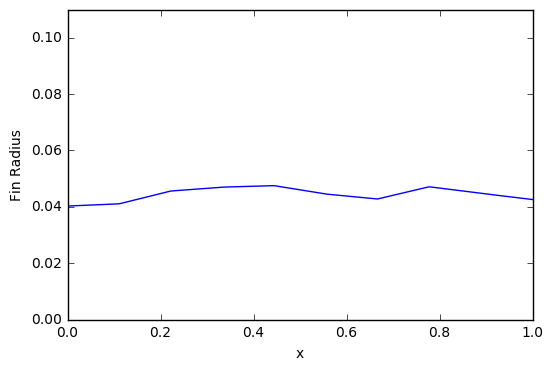

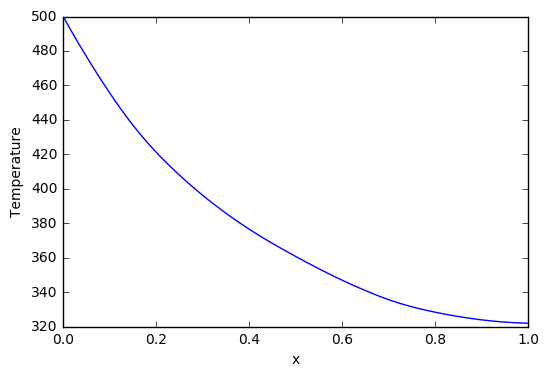

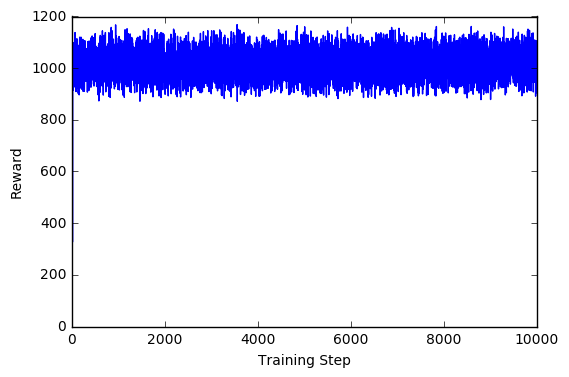

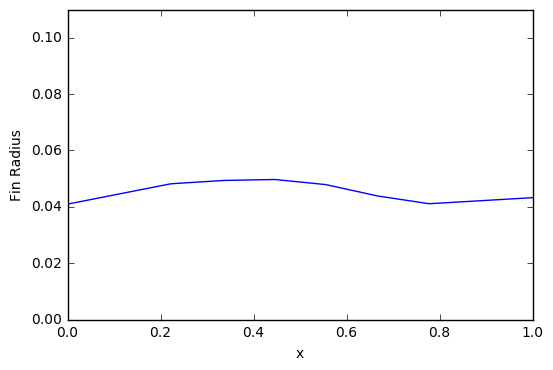

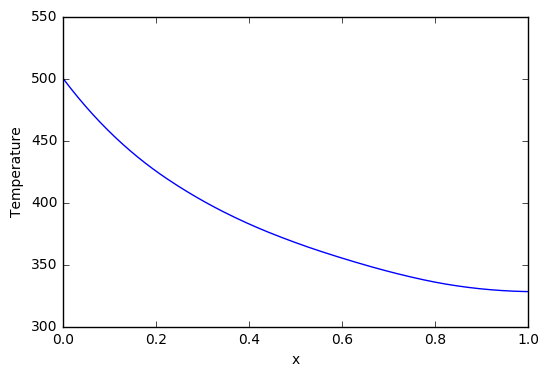

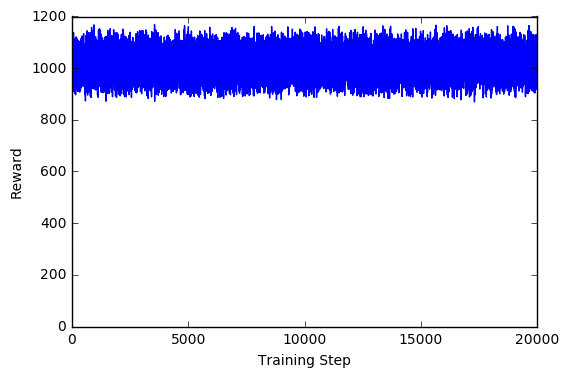

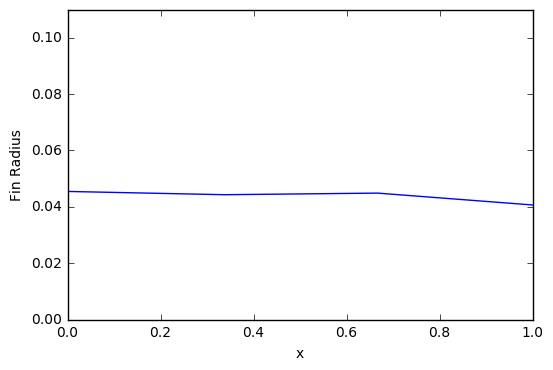

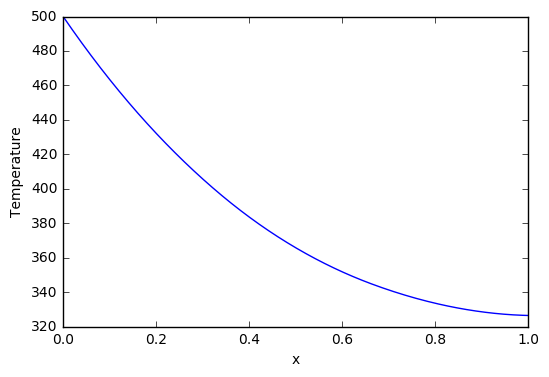

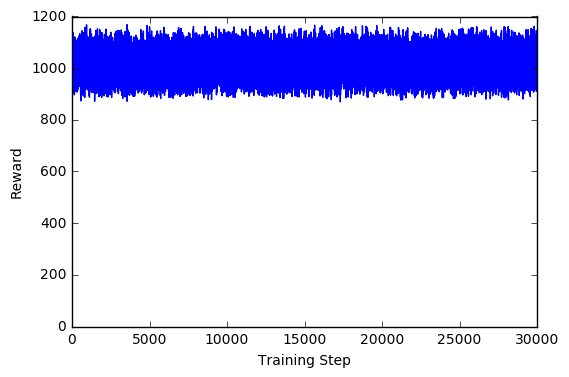

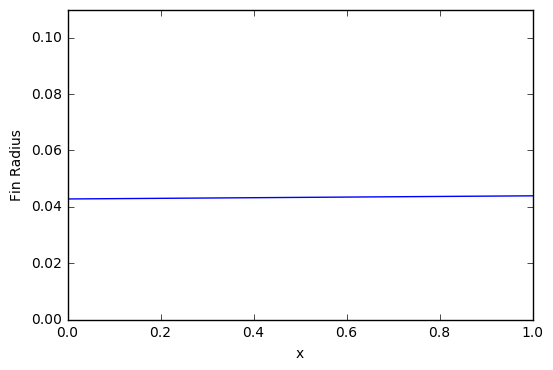

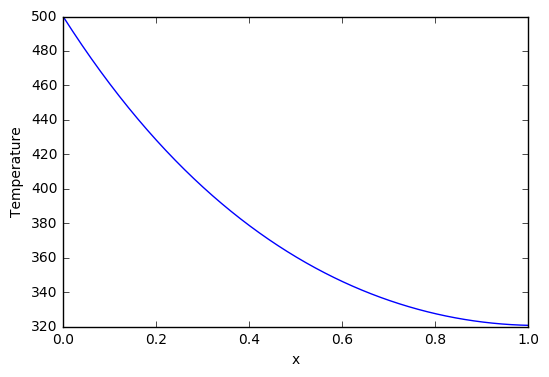

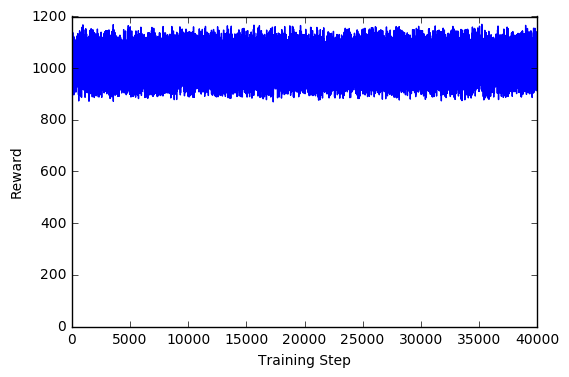

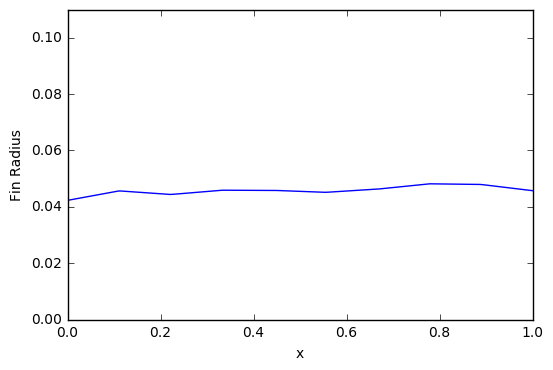

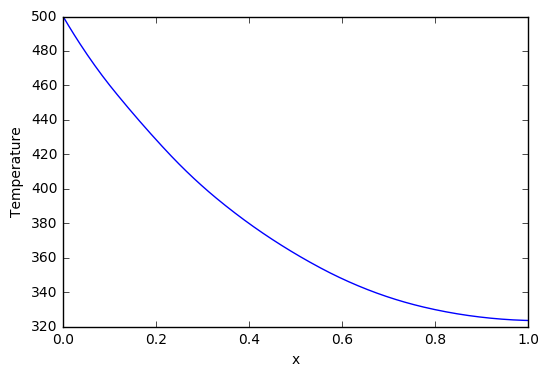

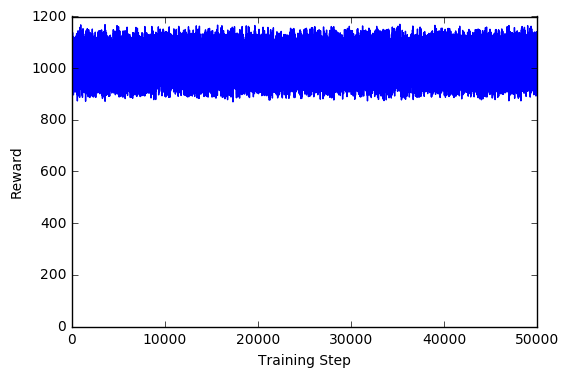

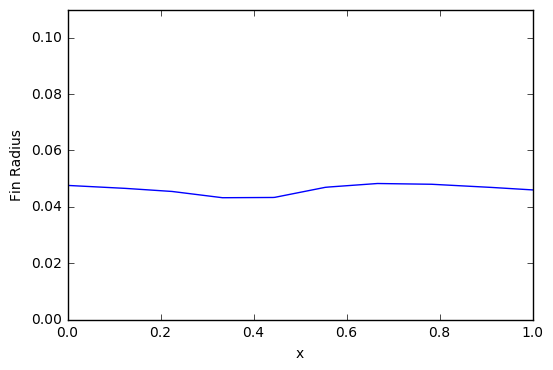

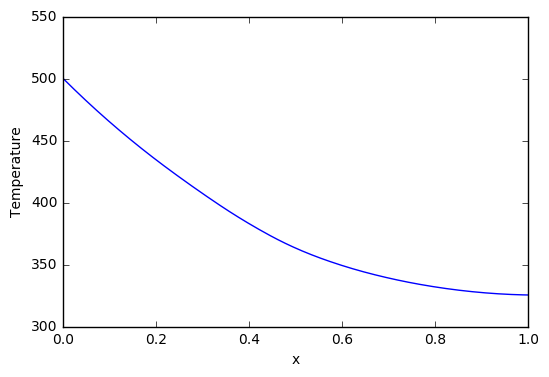

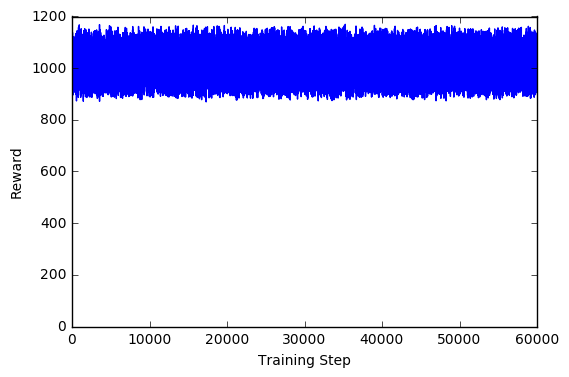

In [2]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=60000, log_interval=6000,visualize=False, verbose=1, nb_max_episode_steps=50)

# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

In [3]:
# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=False, nb_max_episode_steps=1000)

Testing for 5 episodes ...
[  4.37677694e-02   4.25813830e-02   4.41523680e-02   4.84807245e-02
   4.81594572e-02   4.56033998e-02   4.08125522e-02   4.32829892e-02
   4.49879801e-02   4.59275250e-02   5.00000000e+02   4.55763429e+02
   4.19081420e+02   3.92461807e+02   3.73006756e+02   3.57014558e+02
   3.42897919e+02   3.32109917e+02   3.25958249e+02   3.23554529e+02
   1.00308693e+03   6.31010569e-03]
Episode 1: reward: 1002.456, steps: 1
[  4.03727379e-02   4.05631319e-02   4.07535259e-02   4.09439200e-02
   4.11343140e-02   4.11285032e-02   4.09264877e-02   4.07244721e-02
   4.05224566e-02   4.03204411e-02   5.00000000e+02   4.55602770e+02
   4.19382681e+02   3.90131014e+02   3.66873223e+02   3.48740780e+02
   3.35013581e+02   3.25254335e+02   3.19222674e+02   3.16789681e+02
   8.90569849e+02   5.22535143e-03]
Episode 2: reward: 890.047, steps: 1
[  4.86754178e-02   4.74394718e-02   4.73716413e-02   4.84719262e-02
   4.39542926e-02   4.40023707e-02   4.86161605e-02   4.88262601e-0

In [4]:
print(observation_input)
print(env.observation_space.shape)

Tensor("observation_input:0", shape=(?, 1, 22), dtype=float32)
(22,)


In [5]:
print(agent.nb_actions)
print(action_input)

10
Tensor("action_input:0", shape=(?, 10), dtype=float32)
